# Лабораторная работа 2. Ассоциативные правила

---

**Цель работы**: исследование методов анализа ассоциативных правил.

**Вариант датасета**: 3

In [49]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth
import networkx as nx

import pandas as pd

all_data = pd.read_csv('DataSetA.csv', on_bad_lines='skip')
print(all_data)

       Lassi  Coffee Powder         Butter        Yougurt    Ghee Cheese  \
0       Ghee  Coffee Powder            NaN            NaN     NaN    NaN   
1      Lassi     Tea Powder         Butter         Cheese     NaN    NaN   
2     Cheese     Tea Powder         Panner  Coffee Powder  Butter  Bread   
3     Cheese        Yougurt  Coffee Powder          Sugar  Butter  Sweet   
4      Sugar     Tea Powder           Ghee          Sweet  Panner   Milk   
...      ...            ...            ...            ...     ...    ...   
8726  Panner          Sugar          Bread           Milk  Cheese    NaN   
8727   Sugar          Bread  Coffee Powder         Cheese     NaN    NaN   
8728   Bread         Cheese        Yougurt           Milk     NaN    NaN   
8729    Ghee          Bread        Yougurt          Sugar  Cheese    NaN   
8730  Panner        Yougurt          Bread            NaN     NaN    NaN   

      Unnamed: 6  
0            NaN  
1            NaN  
2            NaN  
3          

#### Анализ транзакций

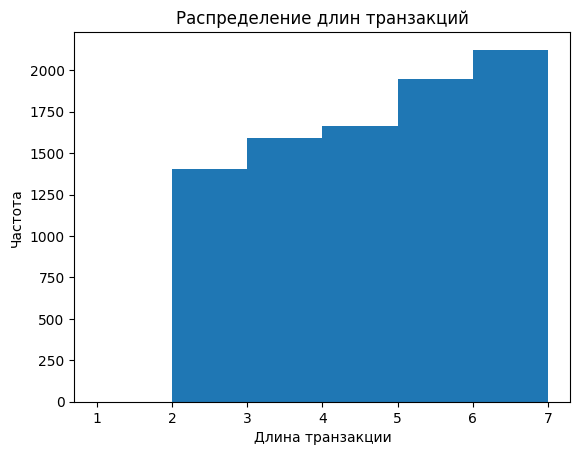

Минимальная длина транзакции: 2
Максимальная длина транзакции: 6
Средняя длина транзакции: 4.21
Медиана длины транзакции: 4.0


In [50]:
transaction_lengths = all_data.notnull().sum(axis=1)
plt.hist(transaction_lengths, bins=range(1, max(transaction_lengths) + 2))
plt.xlabel('Длина транзакции')
plt.ylabel('Частота')
plt.title('Распределение длин транзакций')
plt.show()

print(f"Минимальная длина транзакции: {transaction_lengths.min()}")
print(f"Максимальная длина транзакции: {transaction_lengths.max()}")
print(f"Средняя длина транзакции: {transaction_lengths.mean():.2f}")
print(f"Медиана длины транзакции: {transaction_lengths.median()}")

#### Очистка данных

In [51]:

np_data = all_data.to_numpy()
np_data = [[elem for elem in row[1:] if isinstance(elem,str)] for row in np_data]

#### Список уникальных товаров

In [52]:
unique_items = set()
for row in np_data:
    for elem in row:
        unique_items.add(elem)
print(f"Уникальных товаров: {len(unique_items)}")
print(unique_items)

te = TransactionEncoder()
te_ary = te.fit(np_data).transform(np_data)
data = pd.DataFrame(te_ary, columns=te.columns_)

Уникальных товаров: 12
{'Sweet', 'Bread', 'Panner', 'Milk', 'Butter', 'Yougurt', 'Sugar', 'Lassi', 'Cheese', 'Tea Powder', 'Coffee Powder', 'Ghee'}


#### Алгоритм Apriori

---

In [53]:
df1 = apriori(data, min_support=0.07, use_colnames = True)
print(df1)
rules = association_rules(df1, metric = "confidence", min_threshold = 0.27)
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])


     support                  itemsets
0   0.268583                   (Bread)
1   0.264002                  (Butter)
2   0.271561                  (Cheese)
3   0.269729           (Coffee Powder)
4   0.274654                    (Ghee)
5   0.261711                   (Lassi)
6   0.271332                    (Milk)
7   0.263429                  (Panner)
8   0.262856                   (Sugar)
9   0.267209                   (Sweet)
10  0.259993              (Tea Powder)
11  0.270988                 (Yougurt)
12  0.070782           (Bread, Cheese)
13  0.071355    (Bread, Coffee Powder)
14  0.071813           (Bread, Panner)
15  0.070553          (Bread, Yougurt)
16  0.072386            (Butter, Ghee)
17  0.070324         (Butter, Yougurt)
18  0.070210   (Cheese, Coffee Powder)
19  0.071469            (Cheese, Ghee)
20  0.071469            (Milk, Cheese)
21  0.071928           (Sweet, Cheese)
22  0.072271         (Cheese, Yougurt)
23  0.075707     (Coffee Powder, Ghee)
24  0.070439     (Milk, C

###### Анализ полученных результатов

Было найдено 9 ассоциативных правил у которых поддержка > 0.07 и  достоверность > 0,27

Интерпретация значений:
- Lift > 1 - сильная ассоциация между товарами
- Lift = 1 - ассоциация отсутствует
- Lift < 1 - наличие одного снижает вероятность появления другого

У всех ассоциативных правил lift практически равен 1, что можно сказать, что ассоциации практически отсутвуют

Классификация ассоциативных правил: полезные и тривиальные
Тривиальными правилами можно назвать:
- (Panner) и (Bread), тк к хлебу скорее всего купят сыр
- (Butter) и (Ghee), тк масла находятся в одном отделе
- (Lassi) и (Sweet), к напитку купят сладость

Остальные ассоциациативные правила можно назвать полезными

##### Поддержка и топ-10 самых популярных продуктов

     support       itemsets
4   0.274654           Ghee
2   0.271561         Cheese
6   0.271332           Milk
11  0.270988        Yougurt
3   0.269729  Coffee Powder
0   0.268583          Bread
9   0.267209          Sweet
1   0.264002         Butter
7   0.263429         Panner
8   0.262856          Sugar
5   0.261711          Lassi
10  0.259993     Tea Powder


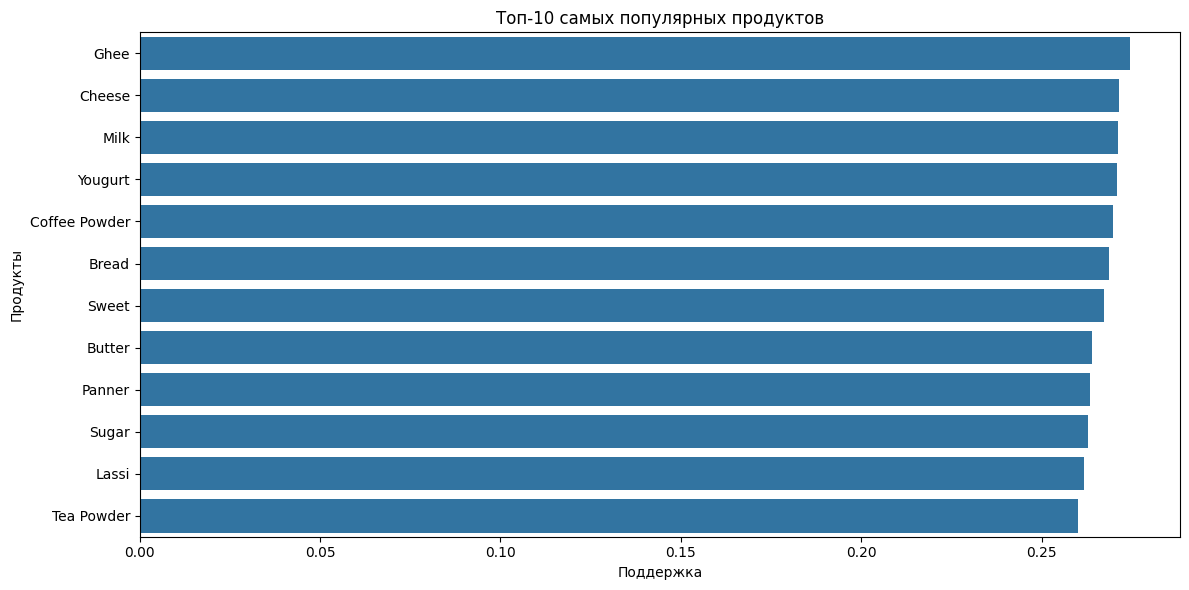

Средняя поддержка для продуктов: 0.267171


In [54]:
df1['itemsets'] = df1['itemsets'].apply(lambda x: ', '.join(list(x)))
top_products = df1.sort_values(by='support', ascending=False).head(12)
print(top_products)
plt.figure(figsize=(12, 6))
sns.barplot(x='support', y='itemsets', data=top_products)
plt.title('Топ-10 самых популярных продуктов')
plt.xlabel('Поддержка')
plt.ylabel('Продукты')
plt.tight_layout()
plt.show()
rules['antecedents'] = rules['antecedents'].apply(lambda x: ', '.join(list(x)))
rules['consequents'] = rules['consequents'].apply(lambda x: ', '.join(list(x)))

print(f"Средняя поддержка для продуктов: {top_products['support'].mean():.6f}")


**Вывод**: cамое высокое значение support среди товаров имеет Gnee (0.274654), в основном поддержка у большинства одиночных товаров ≈ 0.267171
Самым популярным товаром являеется Gnee, но если смотреть общую картину, можно сказать что:
- Все продукты пользуются примерно одинаковой популярностью
- Покупательские предпочтения распределены равномерно
- Стабильный спрос на всю продуктовую линейку

##### График достоверности используемых правил

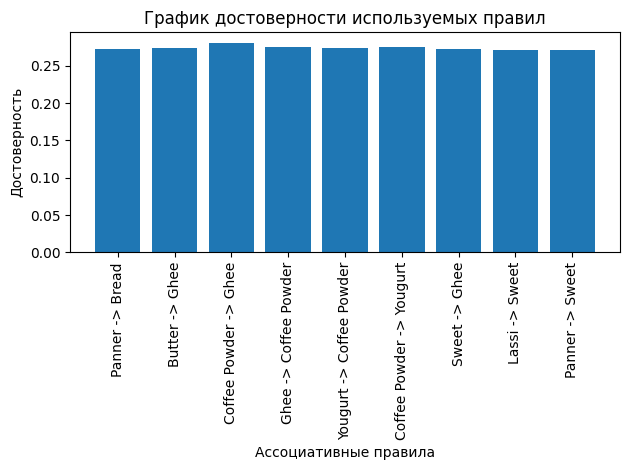

In [55]:
products_1 = rules["antecedents"].tolist()
products_2 = rules["consequents"].tolist()
confidence = rules["confidence"].tolist()
rules_labels = [f"{product1} -> {product2}" for product1, product2 in zip(products_1, products_2)]
plt.bar(rules_labels, confidence)
plt.xlabel("Ассоциативные правила")
plt.ylabel("Достоверность")
plt.title("График достоверности используемых правил")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


Получены 9 ассоциативных правил у которых достоверность > 0,27
Практически у всех правил одинаковая достоверность, около 0,27, можно сказать что:
- Однородность покупательского поведения
- Отсутствие ярко выраженных паттернов

В совокупности по результатам анализа support, confidence, lift, можно сказать, что:
- Все обнаруженные правила статистически незначимы. То есть покупка одного товара не увеличивает вероятность покупки другого
- Все эти продукты являются одинаково востребованными и популярными, так как являются стандартными для потребительской корзины

##### Визуализация ассоциативных правил в виде графа

<Figure size 1200x800 with 0 Axes>

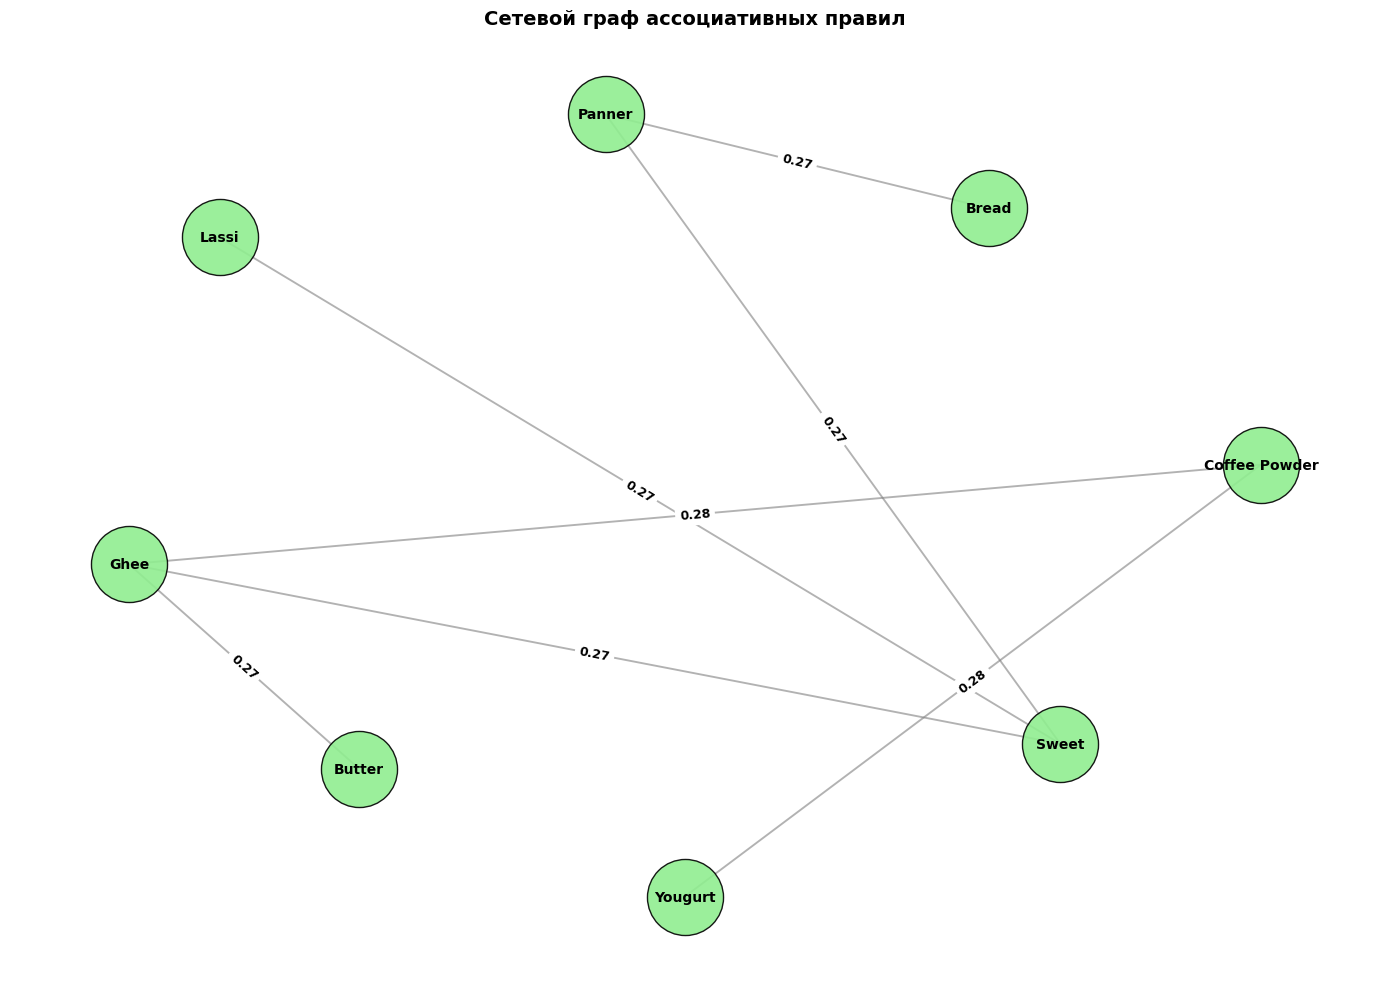

In [56]:
plt.figure(figsize=(12, 8))

G = nx.Graph()

for index, row in rules.iterrows():
    G.add_edge(row['antecedents'], row['consequents'], weight=row['confidence'])


pos = nx.spring_layout(G, k=3, iterations=50)

plt.figure(figsize=(14, 10))
nx.draw_networkx_nodes(G, pos, 
                      node_size=3000, 
                      node_color='lightgreen',
                      alpha=0.9,
                      edgecolors='black')

edge_widths = [d['weight'] * 5 for (u, v, d) in G.edges(data=True)]
nx.draw_networkx_edges(G, pos, 
                      width=edge_widths, 
                      alpha=0.6, 
                      edge_color='gray')


nx.draw_networkx_labels(G, pos, 
                       font_size=10, 
                       font_weight='bold',
                       font_family='sans-serif')


edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, 
                            edge_labels=edge_labels,
                            font_size=9,
                            font_weight='bold')

plt.title('Сетевой граф ассоциативных правил', fontsize=14, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

На построенном графе можно увидеть связи товаров и значение достоверности ассоциации между ними. То есть по числам на ребрах графа можно определить с какой вероятностью будет куплен товар Б, если покупается товар А.
- У всех одинаковая вероятность покупки товара Б при покупке товара А (Единое покупательское пространство)
- Больше всех ассоциаций у Sweet и Gnee (по 3 узла):
    - Масло является базовым пищевым ингредиентом, что объяняет такое количество узлов
    - Сладость выполняет роль универсального дополнения к покупке

**Вывод:** у нас сбалансированность ассортимента и отсутствие лидеров среди продуктов в ассоциациях

In [57]:
results = []
supports = [0.01, 0.02, 0.065]
confidences = [0.1, 0.25, 0.3]

for sup in supports:
    for conf in confidences:
        freq_items = apriori(data, min_support=sup, use_colnames=True)
        rule_set = association_rules(freq_items, metric="confidence", min_threshold=conf)

        num_rules = len(rule_set)
        avg_confidence = rule_set['confidence'].mean() if num_rules > 0 else 0
        avg_lift = rule_set['lift'].mean() if num_rules > 0 else 0
        useful_rules = len(rule_set[rule_set['lift'] > 1])

        results.append({
            'support': sup,
            'confidence': conf,
            'num_rules': num_rules,
            'avg_confidence': avg_confidence,
            'avg_lift': avg_lift,
        })

results_df = pd.DataFrame(results)
print(results_df)

   support  confidence  num_rules  avg_confidence  avg_lift
0    0.010        0.10        792        0.236994  0.887077
1    0.010        0.25        209        0.260096  0.969416
2    0.010        0.30          0        0.000000  0.000000
3    0.020        0.10        132        0.256656  0.960664
4    0.020        0.25         99        0.260235  0.971279
5    0.020        0.30          0        0.000000  0.000000
6    0.065        0.10        124        0.257377  0.962355
7    0.065        0.25         99        0.260235  0.971279
8    0.065        0.30          0        0.000000  0.000000


**Выводы:**
- Из данной таблицы можно увидеть, что при максимально достоверности равной 0.03 ассоциативные правила отсутвуют вообще, поэтому и средний lift равен 0
- Максимальное количество правил (792) при самой минимальной поддержке = 0.01, и минимальной достоверности = 0.1
- При повышении порога достоверности (min_confidence) отсеиваются менее надёжные правила, что приводит к росту среднего значения lift остаются только сильные ассоциации (при увелиении с 0,10 до 0,25)
- При увеличении порога поддержки (min_support) резко сокращается количество частых наборов (itemsets) и, как следствие, число правил при этом средний lift снижается, так как теряются редкие, но значимые комбинации

#### Алгоритм FPG

---

In [58]:
df1 = fpgrowth(data, min_support=0.07, use_colnames = True)
print(df1)
rules = association_rules(df1, metric = "confidence", min_threshold = 0.27)
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])


     support                  itemsets
0   0.269729           (Coffee Powder)
1   0.271561                  (Cheese)
2   0.264002                  (Butter)
3   0.259993              (Tea Powder)
4   0.268583                   (Bread)
5   0.263429                  (Panner)
6   0.270988                 (Yougurt)
7   0.267209                   (Sweet)
8   0.262856                   (Sugar)
9   0.274654                    (Ghee)
10  0.271332                    (Milk)
11  0.261711                   (Lassi)
12  0.074218  (Yougurt, Coffee Powder)
13  0.075707     (Coffee Powder, Ghee)
14  0.070210   (Cheese, Coffee Powder)
15  0.070439     (Milk, Coffee Powder)
16  0.071469            (Cheese, Ghee)
17  0.070324         (Butter, Yougurt)
18  0.072386            (Butter, Ghee)
19  0.071355    (Bread, Coffee Powder)
20  0.070782           (Bread, Cheese)
21  0.070553          (Bread, Yougurt)
22  0.071813           (Bread, Panner)
23  0.071469           (Sweet, Panner)
24  0.072271         (Che

**Вывод**: В результате применения алгоритма FPG было получено также 8 ассоциативных правил. Результаты полность совпадают с результатом алгоритма Apriori




##### Алгоритмически определить минимальные значения поддержки для составления правил из 1, 2, и т.д. объектов в одном из алгоритмов

In [61]:
def find_min_support_for_item_count(data, max_items=5, min_supp_start=0.000001):
    df1 = fpgrowth(data, min_support=min_supp_start, use_colnames=True)
    rules = association_rules(df1, metric="confidence", min_threshold=0.0)
    
    results = {}
    
    # Анализируем наборы товаров из df1 (включая одиночные товары)
    for item_count in range(1, max_items + 1):
        # Для наборов товаров (включая 1 товар)
        df1['items_count'] = df1['itemsets'].apply(len)
        itemsets_filtered = df1[df1['items_count'] == item_count]
        
        print(f"Наборы из {item_count} товара(ов):")
        
        if len(itemsets_filtered) > 0:
            min_support = itemsets_filtered['support'].min()
            max_support = itemsets_filtered['support'].max()
            print(f"Минимальный support: {min_support:.6f}")
            print(f"Максимальный support: {max_support:.6f}")
            print(f"Количество наборов: {len(itemsets_filtered)}")
            
            # Выводим несколько примеров
            for idx, row in itemsets_filtered.head(3).iterrows():
                items = list(row['itemsets'])
                print(f"  {items}: support={row['support']:.4f}")
            
            results[item_count] = min_support
        else:
            print("Нет наборов для такого количества товаров")
            results[item_count] = None
        
        print("-" * 50)
    
    return results

min_supports = find_min_support_for_item_count(data)

Наборы из 1 товара(ов):
Минимальный support: 0.259993
Максимальный support: 0.274654
Количество наборов: 12
  ['Coffee Powder']: support=0.2697
  ['Cheese']: support=0.2716
  ['Butter']: support=0.2640
--------------------------------------------------
Наборы из 2 товара(ов):
Минимальный support: 0.064139
Максимальный support: 0.075707
Количество наборов: 66
  ['Yougurt', 'Coffee Powder']: support=0.0742
  ['Coffee Powder', 'Ghee']: support=0.0757
  ['Cheese', 'Coffee Powder']: support=0.0702
--------------------------------------------------
Наборы из 3 товара(ов):
Минимальный support: 0.012255
Максимальный support: 0.019700
Количество наборов: 220
  ['Yougurt', 'Coffee Powder', 'Ghee']: support=0.0195
  ['Cheese', 'Coffee Powder', 'Ghee']: support=0.0189
  ['Milk', 'Cheese', 'Coffee Powder']: support=0.0189
--------------------------------------------------
Наборы из 4 товара(ов):
Минимальный support: 0.001603
Максимальный support: 0.004581
Количество наборов: 495
  ['Milk', 'Cheese'

Можно сделать вывод, что:
- Минимальный support для 1 товара: 0.259993
- Минимальный support для 2 товара: 0.064139
- Минимальный support для 3 товара: 0.012255
- Минимальный support для 4 товара: 0.001603
- Минимальный support для 5 товара: 0.000115

Это говорит о том, что:
- Корзины из 5 товаров являются редкими
- При увеличении числа товаров, уменьшается support, то есть чеков с большим кол-вом товаров очень мало, уменьшается кол-во чеков с большим кол-вом товаров

##### Предложить и реализовать свой способ визуализации ассоциативных правил и метрик

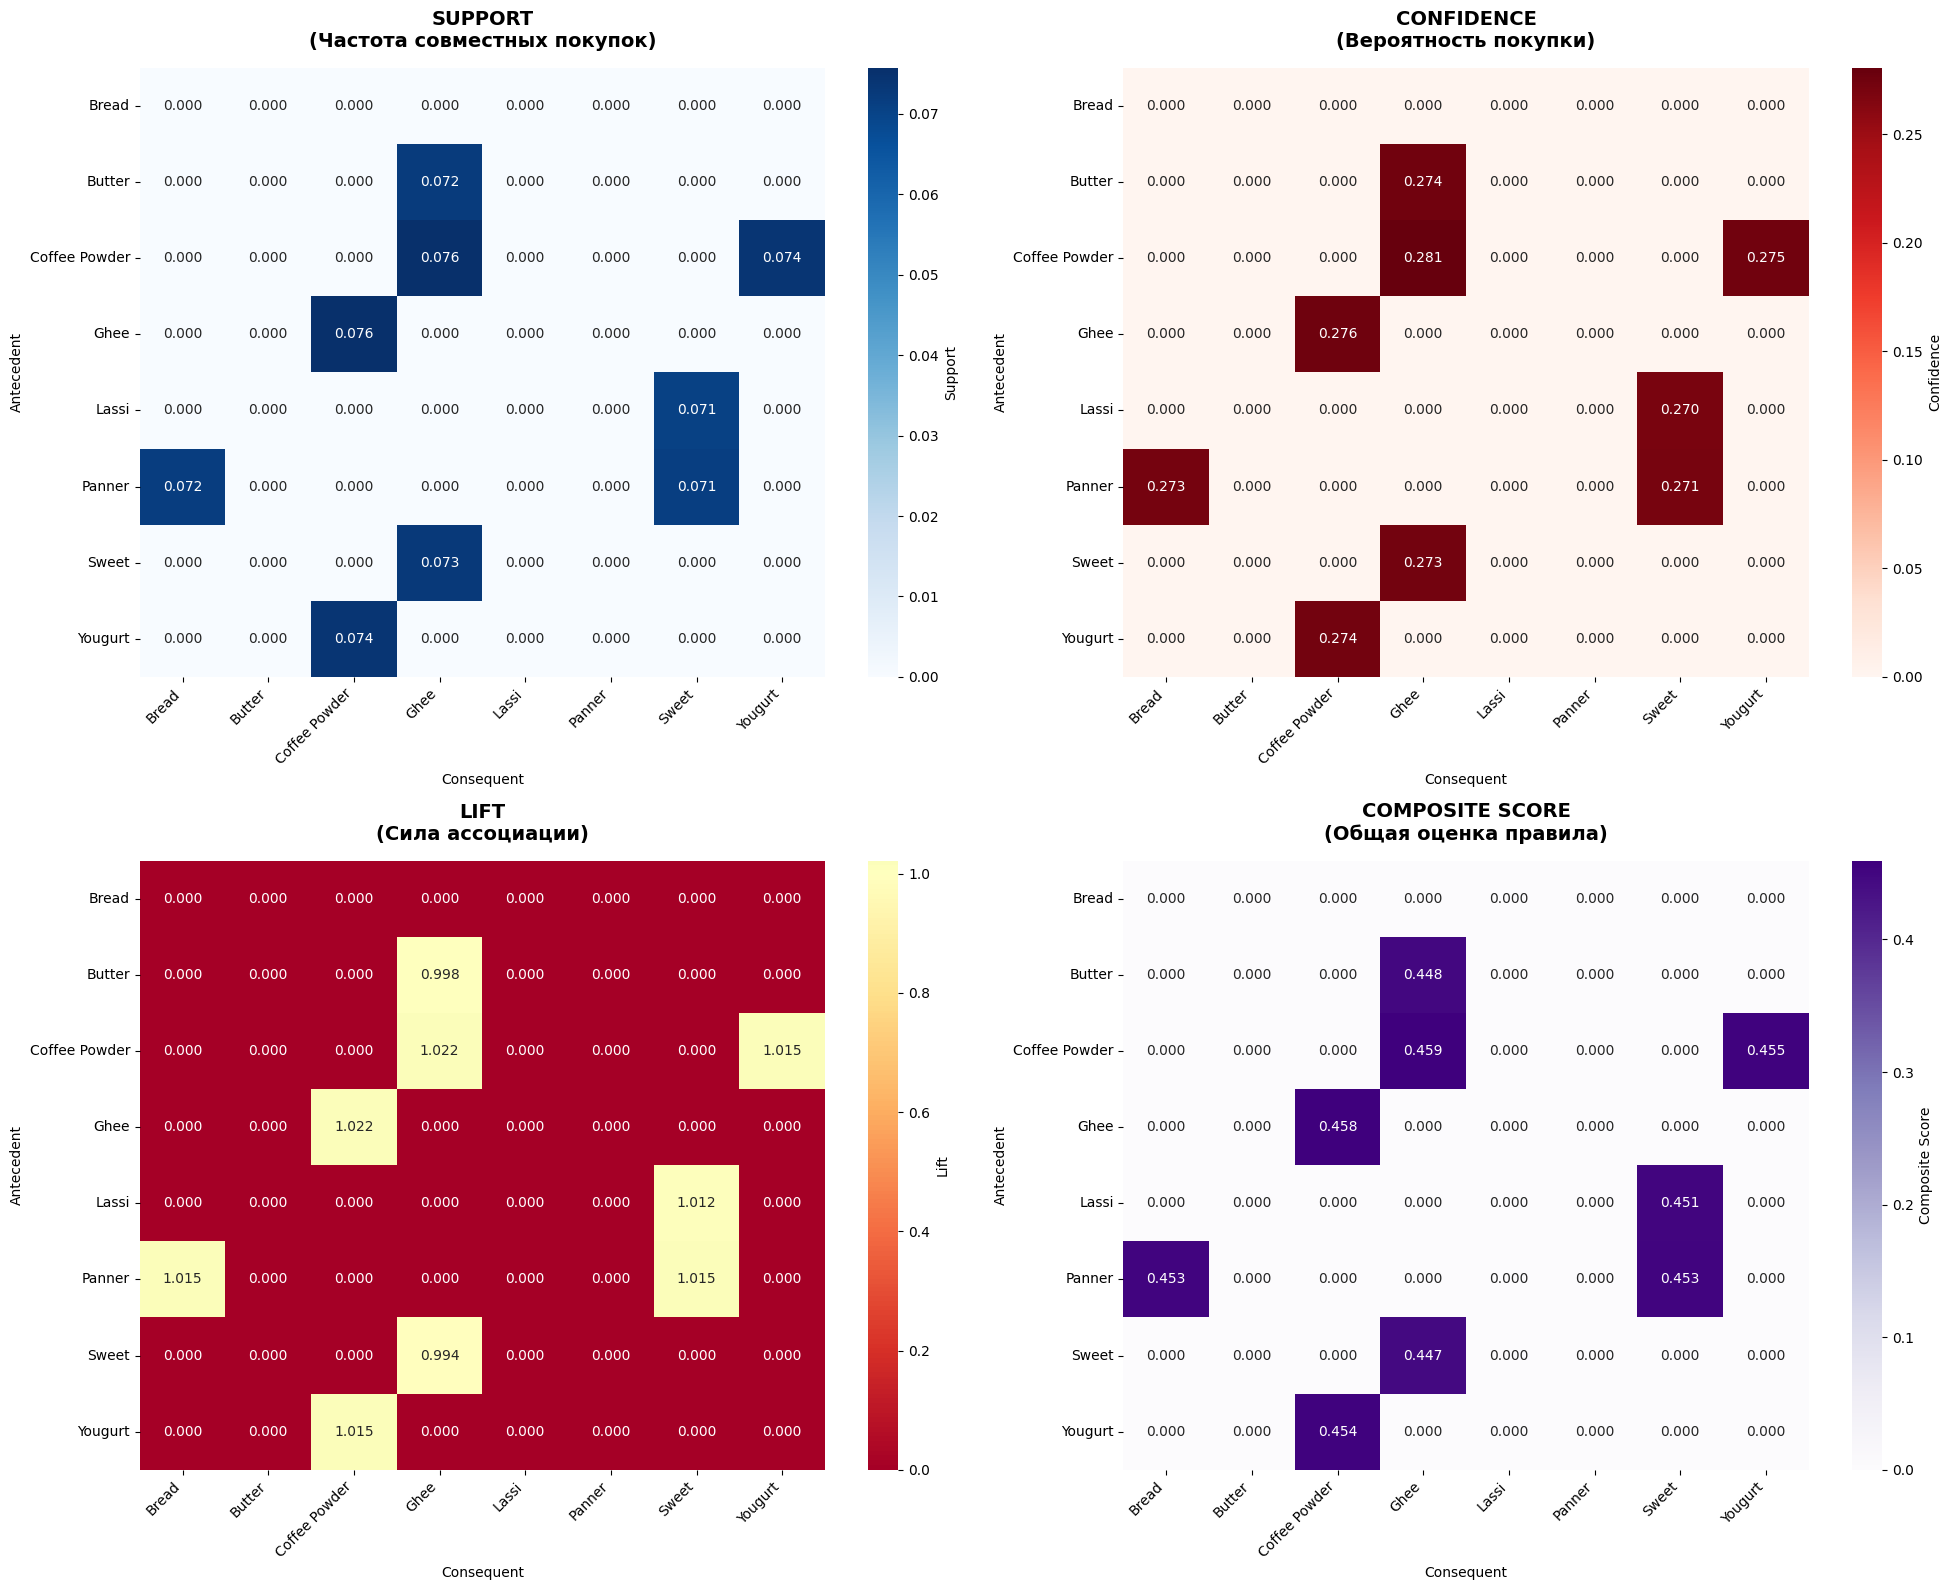

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def create_four_metrics_heatmap(rules_df):
    """
    4 матрицы: Support, Confidence, Lift и Composite Score
    """
    all_antecedents = set()
    all_consequents = set()
    
    for _, row in rules_df.iterrows():
        all_antecedents.update(row['antecedents'])
        all_consequents.update(row['consequents'])
    
    all_products = sorted(list(all_antecedents.union(all_consequents)))
    
    
    matrix_size = len(all_products)
    support_matrix = np.zeros((matrix_size, matrix_size))
    confidence_matrix = np.zeros((matrix_size, matrix_size))
    lift_matrix = np.zeros((matrix_size, matrix_size))
    composite_matrix = np.zeros((matrix_size, matrix_size))
    
    
    product_to_idx = {product: i for i, product in enumerate(all_products)}
    
    for _, rule in rules_df.iterrows():
        ante = list(rule['antecedents'])[0]
        cons = list(rule['consequents'])[0]
        
        i = product_to_idx[ante]
        j = product_to_idx[cons]
        
        support_matrix[i, j] = rule['support']
        confidence_matrix[i, j] = rule['confidence']
        lift_matrix[i, j] = rule['lift']
        
        composite_matrix[i, j] = (rule['support'] + rule['confidence'] + rule['lift']) / 3
    
    
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    

    sns.heatmap(support_matrix, 
                xticklabels=all_products,
                yticklabels=all_products,
                annot=True, fmt='.3f',
                cmap='Blues',
                cbar_kws={'label': 'Support'},
                ax=axes[0, 0])
    axes[0, 0].set_title('SUPPORT\n(Частота совместных покупок)', 
                         fontsize=14, fontweight='bold', pad=15)
    axes[0, 0].set_xlabel('Consequent')
    axes[0, 0].set_ylabel('Antecedent')
    

    sns.heatmap(confidence_matrix, 
                xticklabels=all_products,
                yticklabels=all_products,
                annot=True, fmt='.3f',
                cmap='Reds',
                cbar_kws={'label': 'Confidence'},
                ax=axes[0, 1])
    axes[0, 1].set_title('CONFIDENCE\n(Вероятность покупки)', 
                         fontsize=14, fontweight='bold', pad=15)
    axes[0, 1].set_xlabel('Consequent')
    axes[0, 1].set_ylabel('Antecedent')
    

    sns.heatmap(lift_matrix, 
                xticklabels=all_products,
                yticklabels=all_products,
                annot=True, fmt='.3f',
                cmap='RdYlGn',
                center=1.0,
                cbar_kws={'label': 'Lift'},
                ax=axes[1, 0])
    axes[1, 0].set_title('LIFT\n(Сила ассоциации)', 
                         fontsize=14, fontweight='bold', pad=15)
    axes[1, 0].set_xlabel('Consequent')
    axes[1, 0].set_ylabel('Antecedent')
    

    sns.heatmap(composite_matrix, 
                xticklabels=all_products,
                yticklabels=all_products,
                annot=True, fmt='.3f',
                cmap='Purples',
                cbar_kws={'label': 'Composite Score'},
                ax=axes[1, 1])
    axes[1, 1].set_title('COMPOSITE SCORE\n(Общая оценка правила)', 
                         fontsize=14, fontweight='bold', pad=15)
    axes[1, 1].set_xlabel('Consequent')
    axes[1, 1].set_ylabel('Antecedent')

    for ax in axes.flat:
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
        plt.setp(ax.get_yticklabels(), rotation=0)
    
    plt.tight_layout()
    
    return plt

# Использование - ОДНА СТРОКА:
create_four_metrics_heatmap(rules)
plt.show()

Было реализовано отображение ассоциативных правил и метрик с помощью тепловых карт


На них можно увидеть support, confidence, lift, composite score
Данные heatmap были созданы при min_support = 0.07 и min_confidence = 0.27
- На пересечении товаров можно увидеть какой Уровень support, confidence, lift у этих пар товаров
- Наиболее популярное ассоциативное правило - Gnee и Cofee Powder (support = 0.076) и у него же самая высока достоверность (0.281)
- Наименее популярное ассоциативное правило - Sweet и Lassi (support = 0.071) и у него же самая низка достоверность (0.27), практически по пороговому значению
- Самый низкий lift у Gnee и Sweet (0,944), практически близок к 1, можно сказать что масло оказывает очень слабое отрицательное влияние на покупку сладости